# Global AI Challenge for Building E&M Facilities
> 人工智能建筑机电比赛

## 比赛介绍
「国际建筑机电人工智能大挑战 – 人工智能大赛」是一场面向全球的比赛，欢迎任何国籍人士报名参加。准确的**冷负荷需求预测**是提高建筑能效的关键要素。在此项比赛中，参赛者须为举办方指定的商业建筑开发基于人工智能的**冷负荷需求预测模型**。

建筑能耗占全世界能源消耗总量的40%。在香港这类高密度城市中，建筑物能耗甚至占到城市总能耗的80%。每年香港在供热、通风及空调所消耗的电费高达123亿港元。建筑节能是实现碳中和所必须的。

本次比赛在给出连续18个月的天气特征数据，训练出模型，并且预测给定七天的冷负荷。

> 提示：此notebook的Code 和 Markdown 区域可通过 Shift + Enter 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

**Note!!!: 由于比赛的规则限制，我并不能将我的完整代码呈现读者，此notebook主要展示我的基础过程。**


In [3]:
from datetime import date, timedelta, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import lightgbm as lgb
import gc
import os

display.set_matplotlib_formats('svg')
debug = False

D:\tensorflow1\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 功能性函数
减少内存占用

In [4]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    遍历数据帧的所有列并修改数据类型以减少内存使用。
    """

    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

模板函数
> 包括对特征求统计学特征，进行独热编码，核函数等......

In [5]:
def encode_onehot(df,column_name):
    feature_df=pd.get_dummies(df[column_name], prefix=column_name)
    all = pd.concat([df.drop([column_name], axis=1),feature_df], axis=1)
    return all

def encode_count(df,column_name):
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df[column_name].values))
    df[column_name] = lbl.transform(list(df[column_name].values))
    return df

def merge_count(df,columns,value,cname):
    add = pd.DataFrame(df.groupby(columns)[value].count()).reset_index()
    add.columns=columns+[cname]
    df=df.merge(add,on=columns,how="left")
    return df

def merge_nunique(df,columns,value,cname):
    add = pd.DataFrame(df.groupby(columns)[value].nunique()).reset_index()
    add.columns=columns+[cname]
    df=df.merge(add,on=columns,how="left")
    return df

def merge_median(df,columns,value,cname):
    add = pd.DataFrame(df.groupby(columns)[value].median()).reset_index()
    add.columns=columns+[cname]
    df=df.merge(add,on=columns,how="left")
    return df

def merge_mean(df,columns,value,cname):
    add = pd.DataFrame(df.groupby(columns)[value].mean()).reset_index()
    add.columns=columns+[cname]
    df=df.merge(add,on=columns,how="left")
    return df

def merge_sum(df,columns,value,cname):
    add = pd.DataFrame(df.groupby(columns)[value].sum()).reset_index()
    add.columns=columns+[cname]
    df=df.merge(add,on=columns,how="left")
    return df

def merge_max(df,columns,value,cname):
    add = pd.DataFrame(df.groupby(columns)[value].max()).reset_index()
    add.columns=columns+[cname]
    df=df.merge(add,on=columns,how="left")
    return df

def merge_min(df,columns,value,cname):
    add = pd.DataFrame(df.groupby(columns)[value].min()).reset_index()
    add.columns=columns+[cname]
    df=df.merge(add,on=columns,how="left")
    return df

def merge_std(df,columns,value,cname):
    add = pd.DataFrame(df.groupby(columns)[value].std()).reset_index()
    add.columns=columns+[cname]
    df=df.merge(add,on=columns,how="left")
    return df

def merge_var(df, columns,value,cname):
    add = pd.DataFrame(df.groupby(columns)[value].var()).reset_index()
    add.columns=columns+[cname]
    df=df.merge(add,on=columns,how="left")
    return df

def feat_count(df, df_feature, fe,value,name=""):
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].count()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_count" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_nunique(df, df_feature, fe,value,name=""):
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].nunique()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_nunique" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_mean(df, df_feature, fe,value,name=""):
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].mean()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_mean" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_kernelMedian(df, df_feature, fe, value, pr, name=""):
    def get_median(a, pr=pr):
        a = np.array(a)
        x = a[~np.isnan(a)]
        n = len(x)
        weight = np.repeat(1.0, n)
        idx = np.argsort(x)
        x = x[idx]
        if n<pr.shape[0]:
            pr = pr[n,:n]
        else:
            scale = (n-1)/2.
            xxx = np.arange(-(n+1)/2.+1, (n+1)/2., step=1)/scale
            yyy = 3./4.*(1-xxx**2)
            yyy = yyy/np.sum(yyy)
            pr = (yyy*n+1)/(n+1)
        ans = np.sum(pr*x*weight) / float(np.sum(pr * weight))
        return ans

    df_count = pd.DataFrame(df_feature.groupby(fe)[value].apply(get_median)).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_mean" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_std(df, df_feature, fe,value,name=""):
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].std()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_std" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_median(df, df_feature, fe,value,name=""):
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].median()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_median" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_max(df, df_feature, fe,value,name=""):
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].max()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_max" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_min(df, df_feature, fe,value,name=""):
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].min()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_min" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_sum(df, df_feature, fe,value,name=""):
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].sum()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_sum" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_var(df, df_feature, fe,value,name=""):
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].var()).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_var" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

def feat_quantile(df, df_feature, fe,value,n,name=""):
    df_count = pd.DataFrame(df_feature.groupby(fe)[value].quantile(n)).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_quantile" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

时间序列画图函数

In [6]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series
    created by the user. The user can define either the 'df' and the 'column'
    or the 'series' and additionally, can also define the 'label', the
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

D:\tensorflow1\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


## 1. 数据载入
df_origin为18个月的原始数据

根据主办方提供的数据，其数据描述如下：
* Timestamp: 观测的时间戳（yyyy-mm-dd hh:mm:ss）
* Average_OAT: 室外平均空气温度（摄氏度）
* Humidity: 室外空气的相对湿度（%）
* UV_Index: 紫外线指数
* Average_Rainfall: 平均降雨量(mm)
* ST_CoolingLoad: 南塔冷负荷
* NT_CoolingLoad: 北塔冷负荷
* CoolingLoad: 南塔北塔冷负荷和，NT_CoolingLoad + ST_CoolingLoad

$Cooling Load = mc ΔT$

* m为流量（L/s）x水密度（1kg/L）
* C为热容量（4.19kJ/kg°C)
* ΔT是进口（回水）和出口（供应）冷却水温度差（°C）

In [7]:
df_origin = pd.read_csv('./dataset/CoolingLoad15months.csv')  # 前面15个月
df_three_months = pd.read_csv('./dataset/last3months.csv')  # 最后三个月
time_format = '%Y/%m/%d %H:%M'
df_origin["Timestamp"] = pd.to_datetime(df_origin["Timestamp"], format=time_format)
df_three_months["Timestamp"] = pd.to_datetime(df_three_months["Timestamp"], format=time_format)
df_origin = df_origin.append(df_three_months, ignore_index=True)
df_origin.head()  # 训练集所有原始数据

,Timestamp,Average_OAT,Humidity,UV_Index,Average_Rainfall,NT_CoolingLoad,ST_CoolingLoad,CoolingLoad
0,2020-04-01 00:00:00,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1,2020-04-01 00:15:00,19.355533,NaN,0.0,0.0,NaN,NaN,NaN
2,2020-04-01 00:30:00,19.404700,NaN,0.0,0.0,NaN,NaN,NaN
3,2020-04-01 00:45:00,19.519700,NaN,0.0,0.0,NaN,NaN,NaN
4,2020-04-01 01:00:00,19.505533,NaN,0.0,0.0,NaN,NaN,NaN


数据描述信息

In [8]:
df_origin.describe()

,Average_OAT,Humidity,UV_Index,Average_Rainfall,NT_CoolingLoad,ST_CoolingLoad,CoolingLoad
count,48212.000000,44134.000000,52608.000000,52608.000000,47507.000000,47226.000000,46341.000000
mean,25.520241,75.914869,1.472141,0.525895,766.487884,1416.346541,2213.195324
std,4.943733,13.969574,2.355057,2.310115,826.352557,1014.998628,1773.047333
min,6.548589,12.473633,0.000000,0.000000,-486.407167,-611.260494,-199.405597
25%,22.196892,69.210633,0.100000,0.000000,161.223740,561.311109,791.466649
50%,27.064600,79.150367,0.400000,0.000000,353.377604,1123.619515,1504.765270
75%,29.225333,85.341267,2.000000,0.000000,1071.359631,2089.177837,3257.652064
max,35.315283,100.461000,22.500000,70.500000,4590.974477,5654.836729,9054.350656


In [9]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Timestamp         52608 non-null  datetime64[ns]
 1   Average_OAT       48212 non-null  float64       
 2   Humidity          44134 non-null  float64       
 3   UV_Index          52608 non-null  float64       
 4   Average_Rainfall  52608 non-null  float64       
 5   NT_CoolingLoad    47507 non-null  float64       
 6   ST_CoolingLoad    47226 non-null  float64       
 7   CoolingLoad       46341 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 3.2 MB


直接转换为df_clean

In [10]:
df_clean = df_origin
df_clean.describe()

,Average_OAT,Humidity,UV_Index,Average_Rainfall,NT_CoolingLoad,ST_CoolingLoad,CoolingLoad
count,48212.000000,44134.000000,52608.000000,52608.000000,47507.000000,47226.000000,46341.000000
mean,25.520241,75.914869,1.472141,0.525895,766.487884,1416.346541,2213.195324
std,4.943733,13.969574,2.355057,2.310115,826.352557,1014.998628,1773.047333
min,6.548589,12.473633,0.000000,0.000000,-486.407167,-611.260494,-199.405597
25%,22.196892,69.210633,0.100000,0.000000,161.223740,561.311109,791.466649
50%,27.064600,79.150367,0.400000,0.000000,353.377604,1123.619515,1504.765270
75%,29.225333,85.341267,2.000000,0.000000,1071.359631,2089.177837,3257.652064
max,35.315283,100.461000,22.500000,70.500000,4590.974477,5654.836729,9054.350656


In [11]:
df_clean.head()

,Timestamp,Average_OAT,Humidity,UV_Index,Average_Rainfall,NT_CoolingLoad,ST_CoolingLoad,CoolingLoad
0,2020-04-01 00:00:00,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1,2020-04-01 00:15:00,19.355533,NaN,0.0,0.0,NaN,NaN,NaN
2,2020-04-01 00:30:00,19.404700,NaN,0.0,0.0,NaN,NaN,NaN
3,2020-04-01 00:45:00,19.519700,NaN,0.0,0.0,NaN,NaN,NaN
4,2020-04-01 01:00:00,19.505533,NaN,0.0,0.0,NaN,NaN,NaN


In [12]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Timestamp         52608 non-null  datetime64[ns]
 1   Average_OAT       48212 non-null  float64       
 2   Humidity          44134 non-null  float64       
 3   UV_Index          52608 non-null  float64       
 4   Average_Rainfall  52608 non-null  float64       
 5   NT_CoolingLoad    47507 non-null  float64       
 6   ST_CoolingLoad    47226 non-null  float64       
 7   CoolingLoad       46341 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 3.2 MB


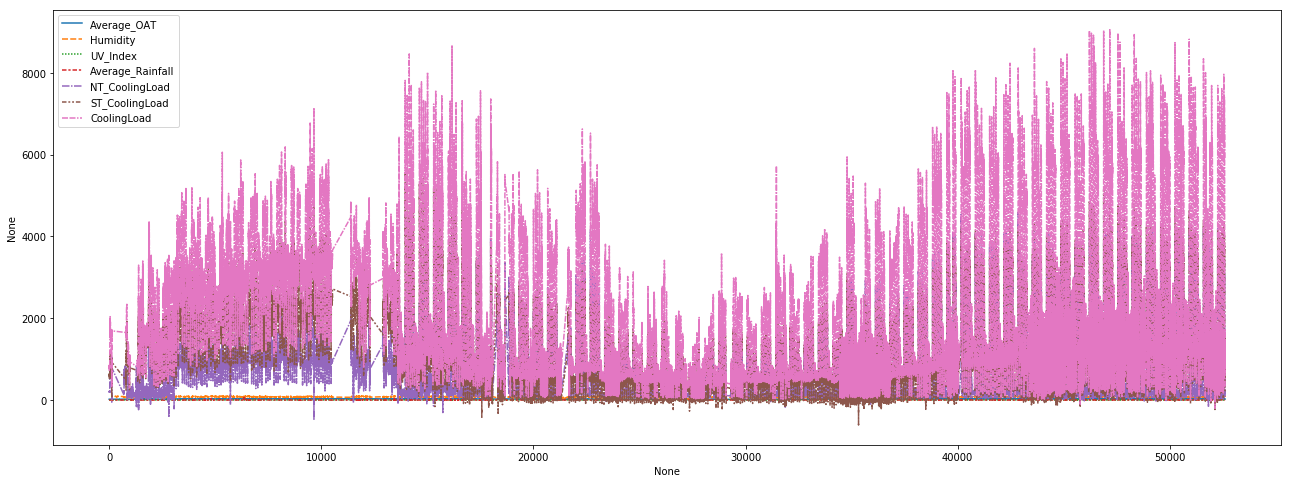

In [13]:
plt.figure(figsize=(22,8))
sns.lineplot(data=df_clean)

查看空值数量

In [14]:
df_clean.isnull().sum(axis=0)

Timestamp              0
Average_OAT         4396
Humidity            8474
UV_Index               0
Average_Rainfall       0
NT_CoolingLoad      5101
ST_CoolingLoad      5382
CoolingLoad         6267
dtype: int64

## 2. 探索性数据分析

观察冷负荷的分布

D:\tensorflow1\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


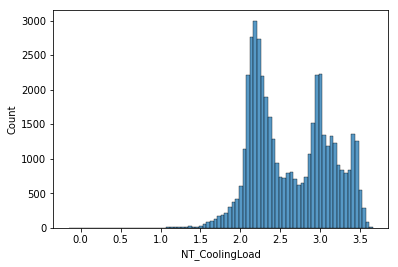

In [15]:
ax = sns.histplot(np.log10(df_clean['NT_CoolingLoad']))

D:\tensorflow1\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


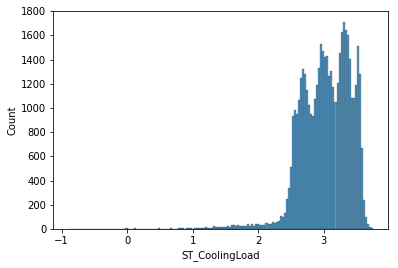

In [16]:
bx = sns.histplot(np.log10(df_clean['ST_CoolingLoad']))

D:\tensorflow1\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


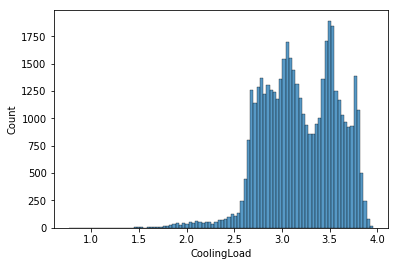

In [17]:
cx = sns.histplot(np.log10(df_clean['CoolingLoad']))

由上面图片可以看出，南塔聚集的冷负荷更高。我们使用时序图来观察一下南塔北塔：

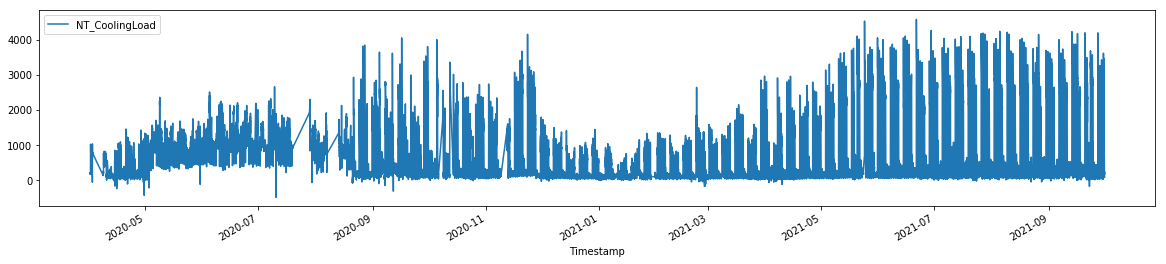

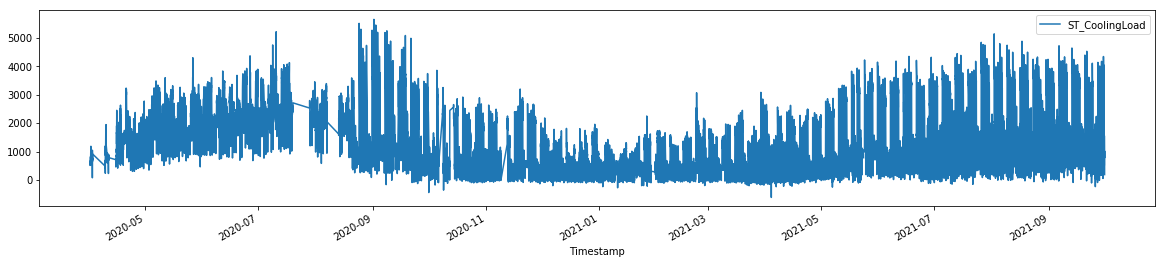

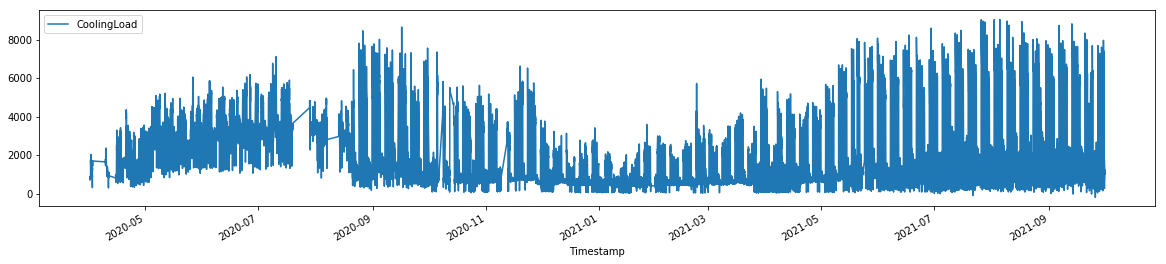

In [18]:
# 时间序列
df_clean.pivot_table(index="Timestamp", values="NT_CoolingLoad").plot(figsize=(20, 4))
plt.show()

df_clean.pivot_table(index="Timestamp", values="ST_CoolingLoad").plot(figsize=(20, 4))
plt.show()

df_clean.pivot_table(index="Timestamp", values="CoolingLoad").plot(figsize=(20, 4))
plt.show()

热力图

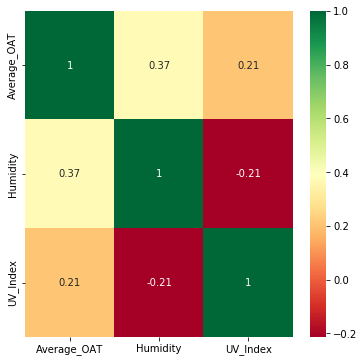

In [19]:
# 协方差 热力图
_, dx = plt.subplots(figsize=(6,6))
columns = df_clean.columns[0: 4]
sns.heatmap(df_clean[columns].corr(), annot=True, cmap='RdYlGn', ax=dx)

## 3. 数据清洗

In [20]:
df_clean.describe()

,Average_OAT,Humidity,UV_Index,Average_Rainfall,NT_CoolingLoad,ST_CoolingLoad,CoolingLoad
count,48212.000000,44134.000000,52608.000000,52608.000000,47507.000000,47226.000000,46341.000000
mean,25.520241,75.914869,1.472141,0.525895,766.487884,1416.346541,2213.195324
std,4.943733,13.969574,2.355057,2.310115,826.352557,1014.998628,1773.047333
min,6.548589,12.473633,0.000000,0.000000,-486.407167,-611.260494,-199.405597
25%,22.196892,69.210633,0.100000,0.000000,161.223740,561.311109,791.466649
50%,27.064600,79.150367,0.400000,0.000000,353.377604,1123.619515,1504.765270
75%,29.225333,85.341267,2.000000,0.000000,1071.359631,2089.177837,3257.652064
max,35.315283,100.461000,22.500000,70.500000,4590.974477,5654.836729,9054.350656


### 异常值 outlier观察
> 实际上不处理结果更好，因此先不做处理

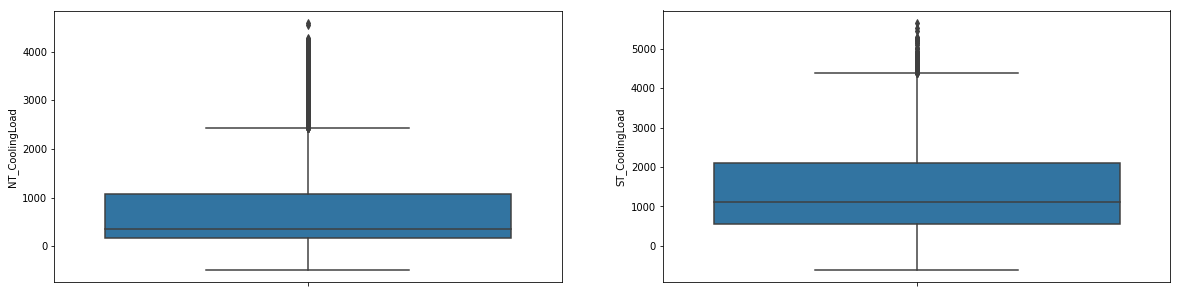

In [21]:
def plot_outlier():
    plt.figure(figsize=(20,5))
    plt.subplot(1, 2, 1)
    sns.boxplot(y='NT_CoolingLoad',data=df_clean)

    plt.subplot(1, 2, 2)
    sns.boxplot(y='ST_CoolingLoad',data=df_clean)
    plt.show()

plot_outlier()

# 异常值处理
def handle_outlier(df, name):
    print(df[name])
    q1 = df[name].quantile(0.25)
    q3 = df[name].quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    med = np.median(df[name])
    for i in df[name]:
        if i > Upper_tail or i < Lower_tail:
            df[name] = df[name].replace(i, med)
    return df

# df_clean = handle_outlier(df_clean, 'NT_CoolingLoad')
# df_clean = handle_outlier(df_clean, 'ST_CoolingLoad')


# plot_outlier()

In [22]:
df_clean.describe()

,Average_OAT,Humidity,UV_Index,Average_Rainfall,NT_CoolingLoad,ST_CoolingLoad,CoolingLoad
count,48212.000000,44134.000000,52608.000000,52608.000000,47507.000000,47226.000000,46341.000000
mean,25.520241,75.914869,1.472141,0.525895,766.487884,1416.346541,2213.195324
std,4.943733,13.969574,2.355057,2.310115,826.352557,1014.998628,1773.047333
min,6.548589,12.473633,0.000000,0.000000,-486.407167,-611.260494,-199.405597
25%,22.196892,69.210633,0.100000,0.000000,161.223740,561.311109,791.466649
50%,27.064600,79.150367,0.400000,0.000000,353.377604,1123.619515,1504.765270
75%,29.225333,85.341267,2.000000,0.000000,1071.359631,2089.177837,3257.652064
max,35.315283,100.461000,22.500000,70.500000,4590.974477,5654.836729,9054.350656


In [23]:
len(df_clean), df_clean.isnull().any(axis=1).sum()  # 一共有548天的数据

(52608, 10845)

## 4. 时间序列特征
处理时间序列：
* year
* month
* day
* time
* weekday
* date
* hour

In [24]:
def date_handle(df):
    """拆分时间日期信息"""
    df.sort_values("Timestamp")  # 按照时间戳来排序
    df.reset_index(drop=True)
    time_format = '%Y/%m/%d %H:%M'
    # 加入其他时间信息
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], format=time_format)
    df["year"] = df["Timestamp"].dt.year
    df["month"] = df["Timestamp"].dt.month
    df["day"] = df["Timestamp"].dt.day
    df["time"] = df["Timestamp"].dt.time
    df["hour"] = df["Timestamp"].dt.hour
    df["weekday"] = df["Timestamp"].dt.weekday
    df["date"] = df["Timestamp"].dt.date
    return df


df_clean = date_handle(df_clean)
df_clean.head()

,Timestamp,Average_OAT,Humidity,UV_Index,Average_Rainfall,NT_CoolingLoad,ST_CoolingLoad,CoolingLoad,year,month,day,time,hour,weekday,date
0,2020-04-01 00:00:00,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2020,4,1,00:00:00,0,2,2020-04-01
1,2020-04-01 00:15:00,19.355533,NaN,0.0,0.0,NaN,NaN,NaN,2020,4,1,00:15:00,0,2,2020-04-01
2,2020-04-01 00:30:00,19.404700,NaN,0.0,0.0,NaN,NaN,NaN,2020,4,1,00:30:00,0,2,2020-04-01
3,2020-04-01 00:45:00,19.519700,NaN,0.0,0.0,NaN,NaN,NaN,2020,4,1,00:45:00,0,2,2020-04-01
4,2020-04-01 01:00:00,19.505533,NaN,0.0,0.0,NaN,NaN,NaN,2020,4,1,01:00:00,1,2,2020-04-01


## 5. 特征空值的填充

In [25]:
def fillna_data(df):
    """特征空值的填充"""
    # 1. 补全部分符合条件的缺失标签
    index1 = ~df["CoolingLoad"].isnull() & ~df["NT_CoolingLoad"].isnull() & df["ST_CoolingLoad"].isnull()
    index2 = ~df["CoolingLoad"].isnull() & ~df["ST_CoolingLoad"].isnull() & df["NT_CoolingLoad"].isnull()

    df.loc[index1, ["ST_CoolingLoad"]] = df[index1]["CoolingLoad"] - df[index1]["NT_CoolingLoad"]
    df.loc[index2, ["NT_CoolingLoad"]] = df[index2]["CoolingLoad"] - df[index2]["ST_CoolingLoad"]

    # 2. 特征插值填充,使用前10天同一时间段的平均值
    df.iloc[:,1:5] = df.groupby("time")["Average_OAT", "Humidity", "UV_Index", "Average_Rainfall"].apply(lambda group: group.interpolate(limit_direction='both'))  # 对四个基础特征进行插值

    # 变回一小时的数据
    # df = df.resample('1H', on="Timestamp").mean()

    df.reset_index(drop=True, inplace=True)
    return df

In [26]:
df_clean = fillna_data(df_clean)
print(df_clean.isnull().sum())  # 观察空值数量

Timestamp              0
Average_OAT            0
Humidity               0
UV_Index               0
Average_Rainfall       0
NT_CoolingLoad      5101
ST_CoolingLoad      5382
CoolingLoad         6267
year                   0
month                  0
day                    0
time                   0
hour                   0
weekday                0
date                   0
dtype: int64


D:\tensorflow1\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


In [27]:
df_clean.head()

,Timestamp,Average_OAT,Humidity,UV_Index,Average_Rainfall,NT_CoolingLoad,ST_CoolingLoad,CoolingLoad,year,month,day,time,hour,weekday,date
0,2020-04-01 00:00:00,19.348867,94.518067,0.0,0.0,NaN,NaN,NaN,2020,4,1,00:00:00,0,2,2020-04-01
1,2020-04-01 00:15:00,19.355533,93.463033,0.0,0.0,NaN,NaN,NaN,2020,4,1,00:15:00,0,2,2020-04-01
2,2020-04-01 00:30:00,19.404700,92.514633,0.0,0.0,NaN,NaN,NaN,2020,4,1,00:30:00,0,2,2020-04-01
3,2020-04-01 00:45:00,19.519700,91.841300,0.0,0.0,NaN,NaN,NaN,2020,4,1,00:45:00,0,2,2020-04-01
4,2020-04-01 01:00:00,19.505533,91.744633,0.0,0.0,NaN,NaN,NaN,2020,4,1,01:00:00,1,2,2020-04-01


### 数据转换
标准化特征函数

In [28]:
def scale_feature(X, column_names):
    """标准化特征"""
    print(columns)
    pre = preprocessing.scale(X[column_names])
    X[column_names] = pre
    return X

## 6. 特征工程
### 6.1 时间特征
* 是否为假日

In [29]:
import holidays
def is_holiday(df):
    """
    判断是不是工作日,0为不是，1为是
    :param df:
    :return:
    """
    # 先通过简单的规则
    df['IsHoliday'] = 0
    # 根据日历制定规则
    holiday = ["2020/4/30", "2020/5/1", "2020/6/25", "2020/7/1", "2020/10/1", "2020/10/2", "2020/10/26", "2020/12/25", "2020/12/26", "2021/1/1", "2021/2/12", "2021/2/13", "2021/2/15", "2021/4/4", "2021/5/1", "2021/6/14", "2021/7/1", "2021/9/22", "2021/10/1", "2021/10/14", "2021/12/21", "2020/12/25"]
    df["IsHoliday"] = df["Timestamp"].apply(lambda x: holidays.HongKong().get(x, default=0))
    holiday_idx = df['IsHoliday'] != 0
    df.loc[holiday_idx, 'IsHoliday'] = 1
    df['IsHoliday'] = df['IsHoliday'].astype(np.uint8)
    return df

### 6.2 天气特征
* 特定分钟下的差值 + delta
* 滞后信息 + lag
    * max, mean, min, std of the specific building historically
* 对平均温度做SG滤波
* 天气聚类

差值计算

In [30]:
def delta_feature(df, minute=30):
    """加入温度差异,在规定的minute中的差异"""
    time_format = "%Y-%m-%d %H:%M:%S"
    delta_time = df["Timestamp"].diff().astype('timedelta64[m]')
    for name in df.iloc[:,1:5]:
        delta = df[name].diff()
        fe_name = "delta_%s_%s_minute" %(name,(str(minute)))
        df[fe_name] = (delta / delta_time) * minute
    return df

加入滞后能力
> 为了提高数据的准确度，使用移动窗口

In [31]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df
    cols = ['Average_OAT', 'Humidity', 'UV_Index', 'Average_Rainfall']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]
    return weather_df

加入同一时间段的统计学特征

In [32]:
def add_same_period_feature(weather_df, window=3):
    group_df = weather_df.groupby("time") # 同一时间段
    cols = ['Average_OAT', 'Humidity', 'UV_Index', 'Average_Rainfall']
    rolled = group_df[cols].rolling(window=window, min_periods=0)

    lag_mean = rolled.mean().reset_index()
    lag_max = rolled.max().reset_index()
    lag_min = rolled.min().reset_index()
    lag_std = rolled.std().reset_index()
    for col in cols:
        weather_df[f'sametime_{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'sametime_{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'sametime_{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'sametime_{col}_std_lag{window}'] = lag_std[col]
    return weather_df

每月相同的那一天滞后

In [33]:
def add_same_day_feature(weather_df, window=3):
    group_df = weather_df.groupby(["day", "time"]) # 同一时间段
    cols = ['Average_OAT', 'Humidity', 'UV_Index', 'Average_Rainfall']
    rolled = group_df[cols].rolling(window=window, min_periods=0)

    lag_mean = rolled.mean().reset_index()
    lag_max = rolled.max().reset_index()
    lag_min = rolled.min().reset_index()
    lag_std = rolled.std().reset_index()
    for col in cols:
        weather_df[f'sameday_{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'sameday_{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'sameday_{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'sameday_{col}_std_lag{window}'] = lag_std[col]
    return weather_df

滤波，时间序列平滑化

In [34]:
from scipy.signal import savgol_filter as sg

def add_sg(df):
    w = 11
    p = 2
    for name in df.loc[:,["Average_OAT"]]:
        df.loc[:, f'{name}_smooth'] = sg(df[name], w, p)
        df.loc[:, f'{name}_diff'] = sg(df[name], w, p, 1)
        df.loc[:, f'{name}_diff2'] = sg(df[name], w, p, 2)
    return df

In [35]:
def avg_rainfall(df):
    """同一日期下（忽略年份）的降水量"""
    df = feat_mean(df, df, ["day", "month"], "Average_Rainfall", name="avg_rainfall")
    return df

In [36]:
def avg_temperature(df):
    """同一日期下（忽略年份）的平均温度"""
    df = feat_mean(df, df, ["day", "month"], "Average_OAT", "avg_temperature")
    return df

In [37]:
def avg_uv(df):
    """同一日期下（忽略年份）的紫外线强度"""
    df = feat_mean(df, df, ["day", "month"], "UV_Index", "avg_UV")
    return df

In [38]:
def avg_humidity(df):
    """同一日期下（忽略年份）的湿度"""
    df = feat_mean(df, df, ["day", "month"], "Humidity", "avg_humidity")
    return df

天气聚类

In [39]:
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(df_clean[['Average_OAT','Humidity','Average_Rainfall']])

找到最优$K$值

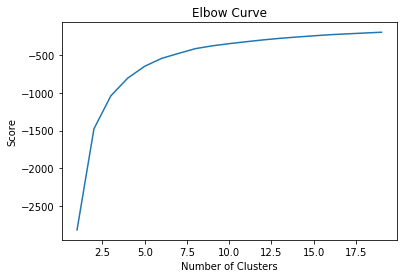

In [40]:
# optimum K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [41]:
kmeans = KMeans(n_clusters=5, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)
df_clean['weather_cluster'] = kmeans.labels_

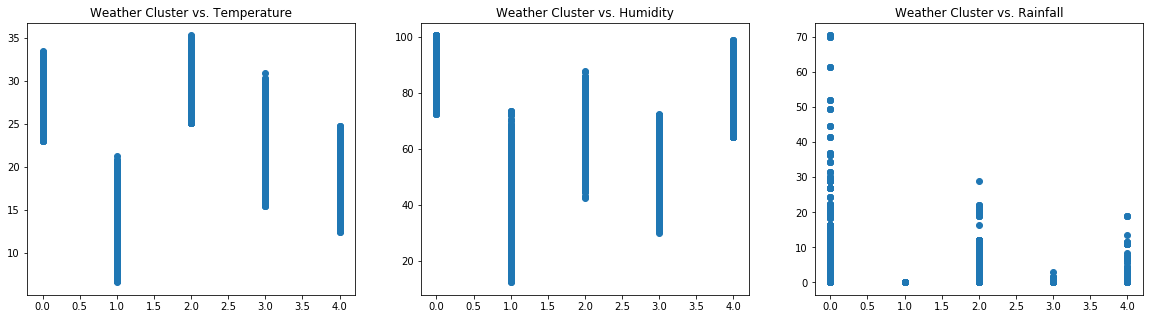

In [42]:
# Cluster Relationships with weather variables
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(df_clean.weather_cluster,df_clean.Average_OAT)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)
plt.scatter(df_clean.weather_cluster,df_clean.Humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)
plt.scatter(df_clean.weather_cluster,df_clean.Average_Rainfall)
plt.title('Weather Cluster vs. Rainfall')

plt.show()


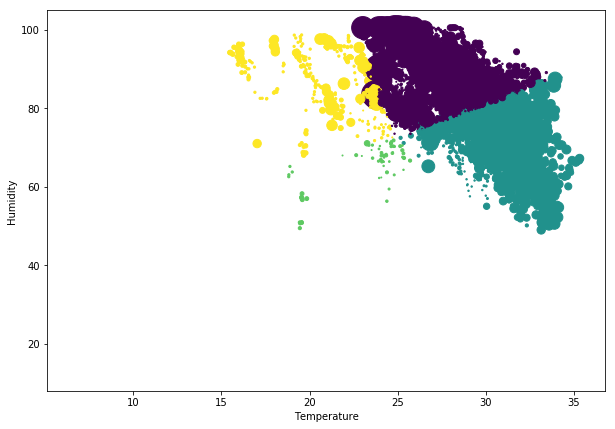

In [43]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(df_clean.Average_OAT,
            df_clean.Humidity,
            s = df_clean.Average_Rainfall*10,
            c = df_clean.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

特征工程函数

In [44]:
def features_engineering(df):
    """特征工程"""
    period_hour = 4
    # 差值计算
    df = delta_feature(df, 15)
    df = delta_feature(df, 30)

    # 同一时间的滞后
    df = add_same_period_feature(df, window=1)
    df = add_same_period_feature(df, window=2)
    df = add_same_period_feature(df, window=3)
    df = add_same_period_feature(df, window=4)
    df = add_same_period_feature(df, window=5)


    # 窗口滞后
    df = add_lag_feature(df, window=3 * period_hour)
    df = add_lag_feature(df, window=5 * period_hour)
    df = add_lag_feature(df, window=12 * period_hour)
    df = add_lag_feature(df, window=24 * period_hour)
    df = add_lag_feature(df, window=48 * period_hour)


    # 加入节假日信息
    df = is_holiday(df)

    # 序列平滑化处理
    df = add_sg(df)

    return df

In [45]:
df_train = features_engineering(df_clean)
df_train = reduce_mem_usage(df_train, use_float16=True)
df_train.head()

D:\tensorflow1\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Memory usage of dataframe is 50.82 MB
Memory usage after optimization is: 20.10 MB
Decreased by 60.5%


,Timestamp,Average_OAT,Humidity,UV_Index,Average_Rainfall,NT_CoolingLoad,ST_CoolingLoad,CoolingLoad,year,month,...,UV_Index_min_lag192,UV_Index_std_lag192,Average_Rainfall_mean_lag192,Average_Rainfall_max_lag192,Average_Rainfall_min_lag192,Average_Rainfall_std_lag192,IsHoliday,Average_OAT_smooth,Average_OAT_diff,Average_OAT_diff2
0,2020-04-01 00:00:00,19.343750,94.5000,0.0,0.0,NaN,NaN,NaN,2020,4,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,19.312500,0.090027,-0.020065
1,2020-04-01 00:15:00,19.359375,93.4375,0.0,0.0,NaN,NaN,NaN,2020,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.390625,0.069946,-0.020065
2,2020-04-01 00:30:00,19.406250,92.5000,0.0,0.0,NaN,NaN,NaN,2020,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.453125,0.049896,-0.020065
3,2020-04-01 00:45:00,19.515625,91.8125,0.0,0.0,NaN,NaN,NaN,2020,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.484375,0.029831,-0.020065
4,2020-04-01 01:00:00,19.500000,91.7500,0.0,0.0,NaN,NaN,NaN,2020,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.515625,0.009773,-0.020065


观察滤波效果

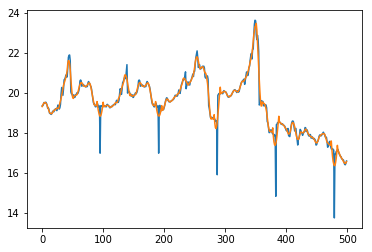

In [46]:
df_train.Average_OAT[:500].plot()
df_train.Average_OAT_smooth[:500].plot()

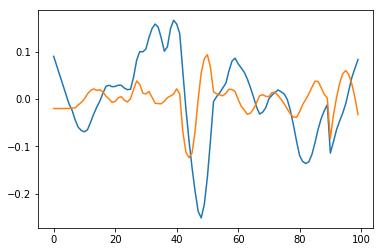

In [47]:
df_train.Average_OAT_diff[:100].plot()
df_train.Average_OAT_diff2[:100].plot()

去掉没有标签的数据

In [48]:
index3 = df_train["CoolingLoad"].isnull()
df_train = df_train[~index3]
print(df_train.isnull().sum())

Timestamp                      0
Average_OAT                    0
Humidity                       0
UV_Index                       0
Average_Rainfall               0
                              ..
Average_Rainfall_std_lag192    0
IsHoliday                      0
Average_OAT_smooth             0
Average_OAT_diff               0
Average_OAT_diff2              0
Length: 188, dtype: int64


### 6.3 切分训练集和测试集

In [49]:
split_valid = df_train["Timestamp"] > '2021-09-24'
df_valid = df_train[split_valid]
df_train = df_train[~split_valid]
drops = ["Timestamp", "year", "day", "time", "date", "month"]
df_train = df_train.drop(drops, axis=1)
df_valid = df_valid.drop(drops, axis=1)

## 7. 模型训练
* 评价函数：
$rmse = \sqrt{\frac{1}{n}(truth - predict)^2}$

* LightGBM模型参数：
    * learning_rate：迭代步长,学习率；
    * num_leaves：LightGBM使用leaf-wise的算法，在调节树的复杂度时，使用num_leaves，较小导致欠拟合，较大导致过拟合；
    * subsample：0-1之间，控制每棵树随机采样的比例，减小这个参数的值，算法会更加保守，避免过拟合。但如果这个值设置得过小，可能会导致欠拟合；
    * lambda_l2：L2正则化系数，用来控制过拟合；
    * num_trees：迭代步数。
    * ......


切分特征和对应标签

In [50]:
y_train_ncl = df_train["NT_CoolingLoad"].reset_index(drop=True)
y_train_scl = df_train["ST_CoolingLoad"].reset_index(drop=True)
y_train_total = df_train["CoolingLoad"].reset_index(drop=True)
X_train = df_train.drop(["NT_CoolingLoad", "ST_CoolingLoad", "CoolingLoad"], axis=1)

y_valid_ncl = df_valid["NT_CoolingLoad"].reset_index(drop=True)
y_valid_scl = df_valid["ST_CoolingLoad"].reset_index(drop=True)
y_valid_total = df_valid["CoolingLoad"].reset_index(drop=True)
X_valid = df_valid.drop(["NT_CoolingLoad", "ST_CoolingLoad", "CoolingLoad"], axis=1)
gc.collect()

17

In [51]:
X_train = X_train.reset_index(drop=True)
print(X_train.isnull().sum())

Average_OAT                    0
Humidity                       0
UV_Index                       0
Average_Rainfall               0
hour                           0
                              ..
Average_Rainfall_std_lag192    0
IsHoliday                      0
Average_OAT_smooth             0
Average_OAT_diff               0
Average_OAT_diff2              0
Length: 179, dtype: int64


训练函数

In [52]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.7):
    """
    lgbm模型训练
    :param train:
    :param val:
    :param devices:
    :param seed:
    :param cat_features:
    :param num_rounds:
    :param lr:
    :param bf:
    :return:
    """
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'rmse'
    params = {'num_leaves': 31,
              'objective': 'regression',
              #               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
    }
    # 配置gpu
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu',
                       'gpu_device_id': device,
                       'gpu_platform_id': device})

    params['seed'] = seed
    early_stop = 100
    verbose_eval = 25

    # star training

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)

    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)

    print('best_score', model.best_score)
    log = {'train/rmse': model.best_score['training']['rmse'],
           'valid/rmse': model.best_score['valid_1']['rmse']}
    return model, y_pred_valid, log

### 开始训练

In [53]:
def plot_feature_important(model):
    """绘制特征重要性图"""
    importance_df = pd.DataFrame(model[1].feature_importance(),
                                 index=X_train.columns,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barch(ax=ax)
    fig.show()

下面使用KFold来对模型进行校验的方法我在Kaggle上面看到很多，但我认为对时间序列做简单的KFold来验证模型并不正确。会导致使用很多的未来数据来预测过去数据的现象，让模型获得了”未卜先知“的能力。在比赛中也很容易造成过拟合的问题。当然如果想了解更多关于时间序列交叉验证的问题可以见[https://zhuanlan.zhihu.com/p/99674163](https://zhuanlan.zhihu.com/p/99674163)

In [54]:
# def train_epochs(X_train, y_train, category_cols, num_rounds=1000, lr=0.1, bf=0.7):
#     """
#     开始训练
#     :param X_train:
#     :param y_train:
#     :param category_cols:
#     :param num_rounds:
#     :param lr:
#     :param bf:
#     :return:
#     """
#     models = []  # 保存每次的模型
#     y_valid_pred_total = np.zeros(X_train.shape[0])
#     for train_idx, valid_idx in kf.split(X_train, y_train):
#         train_data = X_train.iloc[train_idx,:], y_train[train_idx]
#         valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]
#
#         print('train', len(train_idx), 'valid', len(valid_idx))
#
#         model, y_pred_valid, log = fit_lgbm(train_data,valid_data, cat_features=category_cols,
#                                             num_rounds=num_rounds, lr=lr, bf=bf)
#         y_valid_pred_total[valid_idx] = y_pred_valid
#         models.append(model)
#         gc.collect()
#         if debug:
#             break
#
#     try:
#         sns.distplot(y_train)
#         sns.distplot(y_pred_valid)
#         plt.show()
#
#     except:
#         pass
#
#     del X_train, y_train
#     gc.collect()
#
#     print('-------------------------------------------------------------')
#
#     return models

In [55]:
# seed = 666  # 随机种子
# shuffle = True  # 是否打乱
# folds = 78
# kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

In [56]:
categorical_features = ["IsHoliday", "weekday", "weather_cluster"]

In [57]:
def train_model(y_train, y_valid, X_train=X_train, X_valid=X_valid):
    """训练函数"""
    train_data = X_train, y_train
    valid_data = X_valid, y_valid
    print('train', len(X_train), 'valid', len(X_valid))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=categorical_features)
    print(log)
    return model, y_pred_valid, log

北塔

In [58]:
north_model, north_pred, _ = train_model(y_train=y_train_ncl, y_valid=y_valid_ncl)

train 45670 valid 671
training LGB:


D:\tensorflow1\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\tensorflow1\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
D:\tensorflow1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32341
[LightGBM] [Info] Number of data points in the train set: 45670, number of used features: 175
[LightGBM] [Info] Start training from score 772.744525
Training until validation scores don't improve for 100 rounds


D:\tensorflow1\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\tensorflow1\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[25]	training's rmse: 253.707	valid_1's rmse: 308.606
[50]	training's rmse: 198.895	valid_1's rmse: 252.667
[75]	training's rmse: 179.376	valid_1's rmse: 249.074
[100]	training's rmse: 166.68	valid_1's rmse: 246.047
[125]	training's rmse: 157.368	valid_1's rmse: 243.597
[150]	training's rmse: 149.376	valid_1's rmse: 245.157
[175]	training's rmse: 142.755	valid_1's rmse: 239.664
[200]	training's rmse: 137.371	valid_1's rmse: 239.703
[225]	training's rmse: 132.637	valid_1's rmse: 239.798
[250]	training's rmse: 128.25	valid_1's rmse: 240.484
[275]	training's rmse: 124.658	valid_1's rmse: 239.281
Early stopping, best iteration is:
[185]	training's rmse: 140.447	valid_1's rmse: 238.205
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 140.44687755531527)]), 'valid_1': OrderedDict([('rmse', 238.20537883903998)])})
{'train/rmse': 140.44687755531527, 'valid/rmse': 238.20537883903998}


南塔

In [59]:
south_model, south_pred, _ = train_model(y_train=y_train_scl, y_valid=y_valid_scl)

train 45670 valid 671
training LGB:


D:\tensorflow1\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\tensorflow1\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
D:\tensorflow1\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32341
[LightGBM] [Info] Number of data points in the train set: 45670, number of used features: 175
[LightGBM] [Info] Start training from score 1430.794589
Training until validation scores don't improve for 100 rounds


D:\tensorflow1\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\tensorflow1\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[25]	training's rmse: 330.438	valid_1's rmse: 414.069
[50]	training's rmse: 278.444	valid_1's rmse: 373.46
[75]	training's rmse: 260.703	valid_1's rmse: 368.978
[100]	training's rmse: 248.74	valid_1's rmse: 365.544
[125]	training's rmse: 240.35	valid_1's rmse: 365.499
[150]	training's rmse: 233.566	valid_1's rmse: 364.282
[175]	training's rmse: 227.698	valid_1's rmse: 365.171
Early stopping, best iteration is:
[93]	training's rmse: 251.629	valid_1's rmse: 363.501
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('rmse', 251.62870201190364)]), 'valid_1': OrderedDict([('rmse', 363.50083106881306)])})
{'train/rmse': 251.62870201190364, 'valid/rmse': 363.50083106881306}


## 8. 结果预测

In [60]:
total_pred = south_pred + north_pred
np.sqrt(mean_squared_error(total_pred, y_valid_total))  # 总的rmse

D:\tensorflow1\lib\site-packages\numpy\core\_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


513.5399830972136

画对比预测和真实值

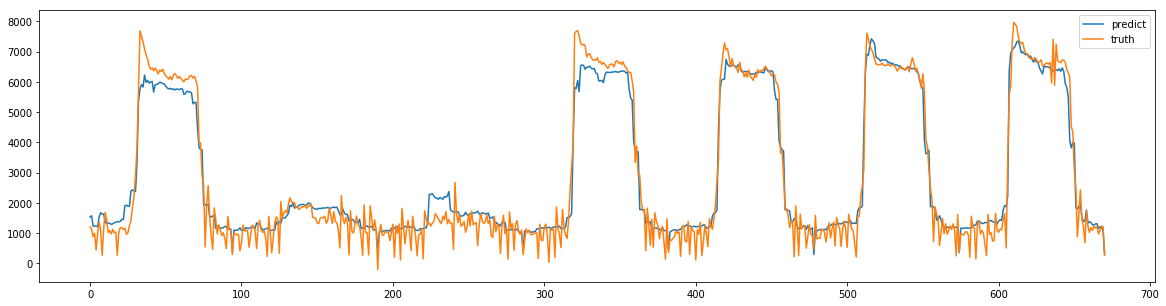

In [61]:
plt.figure(figsize=(20,5))
plt.plot(total_pred, label="predict")
plt.plot(y_valid_total, label="truth")
plt.legend()
plt.show()

## 9. Reference & Future Work

这些Kaggle上的kernel启发了我完成这个notebook，感谢他们的分享！
* [https://www.kaggle.com/rishabhiitbhu/ashrae-simple-eda](https://www.kaggle.com/rishabhiitbhu/ashrae-simple-eda)
* [https://www.kaggle.com/isaienkov/simple-lightgbm](https://www.kaggle.com/rishabhiitbhu/ashrae-simple-eda)
* [https://www.kaggle.com/ryches/simple-lgbm-solution](https://www.kaggle.com/rishabhiitbhu/ashrae-simple-eda)
* [https://www.kaggle.com/patrick0302/postprocessed-models-bland-by-leak](https://www.kaggle.com/patrick0302/postprocessed-models-bland-by-leak)
* [https://www.kaggle.com/rheajgurung/energy-consumption-forecast](https://www.kaggle.com/rheajgurung/energy-consumption-forecast)

可以清楚的看到这个模型对较低CoolingLoad的情况拟合效果并不好，个人主要认为在低的CoolingLoad的情况下，真实值存在明显的震荡，而我的模型无法学习到这些震荡的信息，因此特征工程上或许还需要思考全新的特征。

通过一些尝试，我认为在目前的特征工程工作与LightGBM模型下，七天测试集最优的rmse可以在460左右。我也同时尝试额外使用AutoML进行一些训练，其计算的rmse仍然在500附近。因此或许想要获得更加好的结果，需要在特征工程，特征选择上多下功夫。